In [ ]:
!pip install librosa
!pip install tensorflow
!pip install resampy
import resampy
import tensorflow

from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.0 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import IPython.display as ipd
filepath = "/content/drive/MyDrive/Dataset/AWN/awm_0m_center_0476.mp3"
ipd.Audio(filepath)


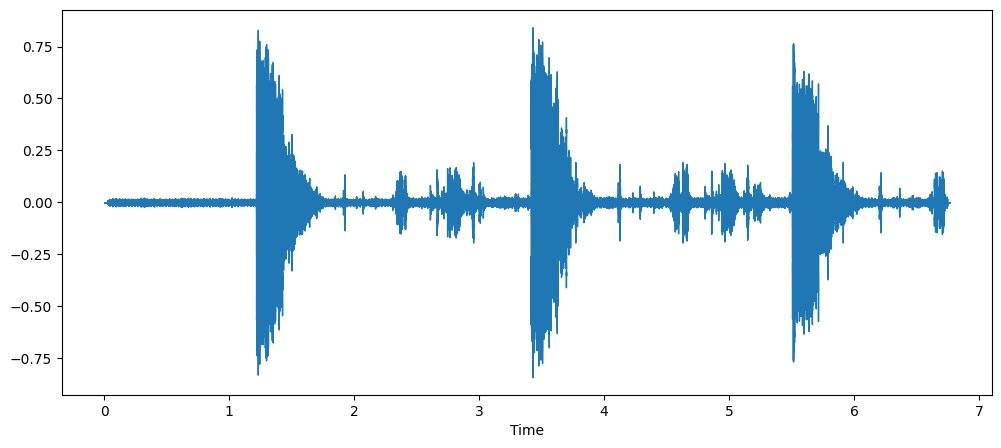

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display


data, sample_rate = librosa.load(filepath)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sample_rate)


In [ ]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)
#file_name = "/content/drive/MyDrive/Dataset"
import pandas as pd
metadata = pd.read_csv('/content/drive/MyDrive/v3_exp1_train.csv')
metadata.head(100)


(40, 292)
[[-4.9793808e+02 -3.9766672e+02 -3.6085004e+02 ... -1.3385988e+02
  -2.0799911e+02 -4.0441742e+02]
 [ 4.9697006e+01  8.1014709e+01  8.5053978e+01 ... -1.3347769e+00
   2.0082993e+01  8.0899078e+01]
 [ 2.2071278e+01  1.2737995e+01  1.0069733e+01 ... -3.2454781e+01
  -1.6471951e+01  2.2155563e+01]
 ...
 [-7.2810102e-01 -2.7565747e-02 -6.7050874e-01 ... -9.2085719e-01
   4.4209647e+00  2.6480699e+00]
 [-3.0755792e+00 -1.6728039e+00 -2.9873271e+00 ... -3.7012794e+00
  -4.0812321e+00 -1.8255453e+00]
 [-1.9540324e+00 -4.8792419e+00 -5.1290207e+00 ... -8.8221109e-01
  -2.6379709e+00  1.0027709e+00]]


,name,cate,dist,dire
0,ak_0m_center_0001.mp3,ak,0m,center
1,ak_0m_center_0002.mp3,ak,0m,center
2,ak_0m_center_0003.mp3,ak,0m,center
3,ak_0m_center_0004.mp3,ak,0m,center
4,ak_0m_center_0006.mp3,ak,0m,center
...,...,...,...,...
95,dp_0m_center_0513.mp3,dp,0m,center
96,g36c_0m_center_0515.mp3,g36c,0m,center
97,g36c_0m_center_0516.mp3,g36c,0m,center
98,g36c_0m_center_0518.mp3,g36c,0m,center


In [ ]:
import numpy as np
import librosa
import resampy

def features_extractor(file_name):
    # load the file (audio)
    audio, sample_rate = librosa.load(file_name, sr=None, res_type=resampy)
    # we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


In [ ]:
import numpy as np
from tqdm import tqdm

audio_dataset_path = "/content/drive/MyDrive/gun_sound_v2"
extracted_features = []

for index_num, row in tqdm(metadata.iterrows()):
    if 'name' in row.index and 'cate' in row.index:
        file_name = os.path.join(os.path.abspath(audio_dataset_path), str(row["name"]))
        final_class_labels = row["cate"]
        data = features_extractor(file_name)
        extracted_features.append([data, final_class_labels])
    else:
        # Handle missing keys or columns in the row
        continue


772it [03:31,  3.65it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['name','cate'])
extracted_features_df.head(100)


,name,cate
0,"[-379.26056, 60.846054, 8.370129, 14.792747, -...",ak
1,"[-352.18033, 60.596504, 1.2691187, 18.305195, ...",ak
2,"[-440.0279, 64.132195, 15.408105, 10.380965, -...",ak
3,"[-316.15103, 70.793076, 3.2806225, 26.262571, ...",ak
4,"[-399.35498, 69.20863, 13.716939, 24.183434, 6...",ak
...,...,...
95,"[-243.67114, 124.12042, -14.955926, 28.509636,...",dp
96,"[-176.53484, 83.29396, -5.437001, 25.584154, -...",g36c
97,"[-134.82436, 120.80796, -27.088291, 30.027763,...",g36c
98,"[-187.28838, 114.72025, -0.66710204, 19.41379,...",g36c


In [ ]:
!pip install tensorflow keras

## Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['name'].tolist())
y=np.array(extracted_features_df['cate'].tolist())
### Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

# Define the number of classes
num_labels = y.shape[1]

# Create the model
model = Sequential([
    Dense(256, input_shape=(40,)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])

# Print model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 700
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/700
18/20 [==========================>...] - ETA: 0s - loss: 4.1116 - accuracy: 0.0330
Epoch 1: val_loss improved from inf to 6.80379, saving model to ./audio_classification.hdf5
20/20 [==============================] - 10s 45ms/step - loss: 4.1178 - accuracy: 0.0324 - val_loss: 6.8038 - val_accuracy: 0.0645
Epoch 2/700
17/20 [========================>.....] - ETA: 0s - loss: 3.7519 - accuracy: 0.0717
Epoch 2: val_loss did not improve from 6.80379
20/20 [==============================] - 0s 16ms/step - loss: 3.7566 - accuracy: 0.0697 - val_loss: 9.9053 - val_accuracy: 0.0645
Epoch 3/700
16/20 [=======================>......] - ETA: 0s - loss: 3.6039 - accuracy: 0.0898
Epoch 3: val_loss did not improve from 6.80379
20/20 [==============================] - 0s 14ms/step - loss: 3.5827 - accuracy: 0.0891 - val_loss: 10.0289 - val_accuracy: 0.0645
Epoch 4/700
19/20 [===========================>..] - ETA: 0s - loss: 3.4752 - accuracy: 0.1086
Epoch 4: val_loss did not improve from 6.8

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print((test_accuracy[1])*100,"%")


98.06451797485352 %


In [ ]:
sample_audio ="/content/drive/MyDrive/gun_sound_v2/deagle_0m_center_1783.mp3"
#sample_audio ="/content/Pubg_ScarL.mp3"
#preprocess the audio file
audio, sample_rate = librosa.load(sample_audio, sr=None, res_type=resampy)
    # we extract mfcc
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # in order to find out scaled feature we do mean of transpose of value
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features)
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
print(prediction_class)

ipd.Audio(sample_audio)


1/1 [==============================] - 0s 44ms/step
[4]
['deagle']


5/5 [==============================] - 0s 3ms/step


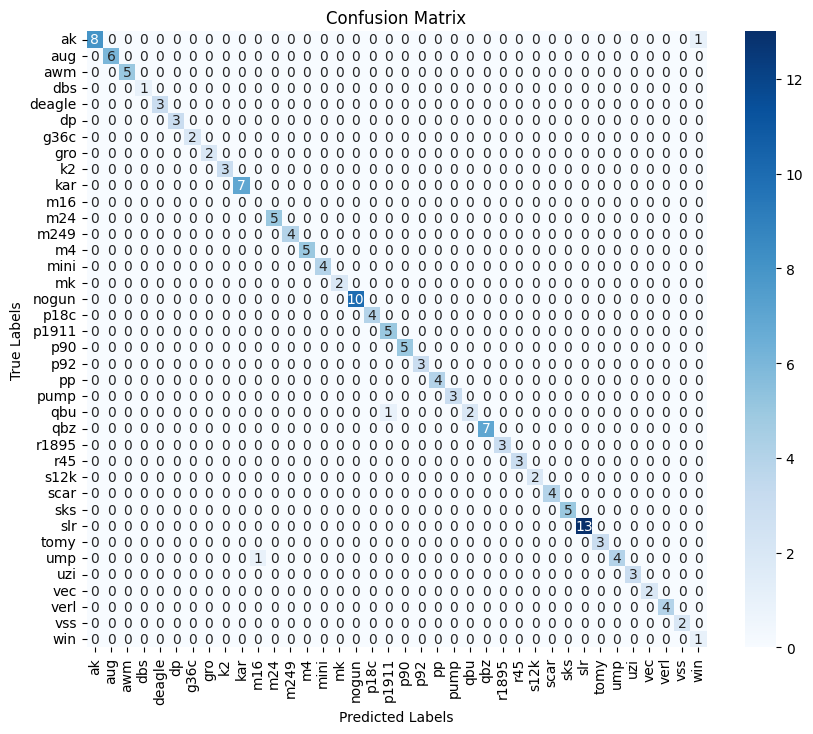

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the predicted labels for the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Get the class labels from the label encoder
class_labels = labelencoder.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
